In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from PIL import Image
import random
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import v2 as transforms
import os



In [17]:
# Set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Menggunakan device: {device}")



Menggunakan device: cuda


In [18]:
# --- Fungsi Utility dan Visualisasi ---
def img_show(number, root_path="/kaggle/input/guns-object-detection/", size=5):
    """Menampilkan gambar dengan bounding box dari file label."""
    image_path = os.path.join(root_path, "Images", f"{number}.jpeg")
    label_path = os.path.join(root_path, "Labels", f"{number}.txt")

    if not os.path.exists(image_path) or not os.path.exists(label_path):
        print(f"File tidak ditemukan: {number}")
        return

    image = cv2.imread(image_path)
    file_data = open(label_path).readlines()
    num_objects = int(file_data[0].strip())

    for i in range(num_objects):
        coords = [int(x) for x in file_data[i+1].split()]
        start_pt = (coords[0], coords[1])
        end_pt = (coords[2], coords[3])
        cv2.rectangle(image, start_pt, end_pt, (0, 0, 255), 2)

    aspect_ratio = image.shape[0] / image.shape[1]
    plt.figure(figsize=(size * aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"No. of guns: {num_objects}")
    plt.axis('off')
    plt.show()



In [19]:
# --- Dataset, Augmentasi dan Dataloader ---
class GunData(Dataset):
    def __init__(self, root, transforms=None):
        self.image_path = os.path.join(root, "Images")
        self.labels_path = os.path.join(root, "Labels")
        self.images = sorted(os.listdir(self.image_path))
        self.transforms = transforms

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0

        label_name = img_name.replace(".jpeg", ".txt")
        label_path = os.path.join(self.labels_path, label_name)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            num_objects = int(lines[0].strip())
            boxes = [list(map(int, line.split())) for line in lines[1:num_objects+1]]

        if not boxes:
            boxes = np.zeros((0, 4), dtype=np.float32)
            labels = np.zeros((0,), dtype=np.int64)
            area = np.zeros((0,), dtype=np.float32)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.ones((len(boxes),), dtype=torch.int64)
            area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

        target = {
            "boxes": boxes,
            "labels": labels,
            "area": area,
            "image_id": torch.tensor([idx])
        }

        # Mengubah target menjadi format yang bisa di-transform
        target_v2 = torchvision.tv_tensors.BoundingBoxes(
            boxes,
            format="XYXY",
            canvas_size=(img.shape[0], img.shape[1])
        )
        target['boxes'] = target_v2

        if self.transforms:
            img, target = self.transforms(torch.from_numpy(img).permute(2,0,1), target)
        else:
            img = torch.as_tensor(img).permute(2, 0, 1)

        return img, target

    def __len__(self):
        return len(self.images)

def collate_fn(batch):
    return tuple(zip(*batch))



In [20]:
# --- Model dan Pelatihan ---
class Model:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.model = self._create_model()
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.patience = 5  # Early stopping patience

    def _create_model(self):
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num_classes)
        return model

    def train_and_validate(self, train_loader, val_loader, optimizer, num_epochs=30):
        self.model.to(device)

        for epoch in tqdm(range(num_epochs)):
            self.model.train()
            train_loss = 0
            for images, targets in train_loader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()
                train_loss += losses.item()
            
            self.train_losses.append(train_loss / len(train_loader))
            val_loss = self._validate(val_loader)

            print(f"\nEpoch: {epoch + 1}/{num_epochs} | Train Loss: {self.train_losses[-1]:.4f} | Validation Loss: {val_loss:.4f}")
            
            # Early Stopping
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.patience_counter = 0
                self.save_model(path="best_model.pth")
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break
        
        self.plot_losses()
        print("Final model saved.")
        self.save_model()

    def _validate(self, val_loader):
        self.model.train() # Mode training agar validasi loss dihitung
        val_loss = 0
        with torch.no_grad():
            for images, targets in val_loader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                val_loss += losses.item()
        
        avg_val_loss = val_loss / len(val_loader)
        self.val_losses.append(avg_val_loss)
        return avg_val_loss

    def save_model(self, path="F_RCNN.pth"):
        torch.save(self.model.state_dict(), path)
        print(f"Model berhasil disimpan di {path}")

    def plot_losses(self):
        """Visualisasi Loss Pelatihan dan Validasi."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Training Loss', marker='o')
        plt.plot(self.val_losses, label='Validation Loss', marker='o')
        plt.title('Training and Validation Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()



In [21]:
# --- Transformasi Data (Augmentasi) ---
# Terapkan hanya pada data training
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # Baris ini telah diperbarui untuk menghilangkan peringatan
    transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)
])



In [22]:
# Validasi tidak menggunakan augmentasi, hanya konversi ke tensor
val_transforms = transforms.Compose([
    # Baris ini telah diperbarui untuk menghilangkan peringatan
    transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)
])



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 1/50 | Train Loss: 0.2672 | Validation Loss: 0.2229
Model berhasil disimpan di best_model.pth

Epoch: 2/50 | Train Loss: 0.1952 | Validation Loss: 0.2092
Model berhasil disimpan di best_model.pth

Epoch: 3/50 | Train Loss: 0.1656 | Validation Loss: 0.2002
Model berhasil disimpan di best_model.pth

Epoch: 4/50 | Train Loss: 0.1483 | Validation Loss: 0.2040

Epoch: 5/50 | Train Loss: 0.1207 | Validation Loss: 0.2104

Epoch: 6/50 | Train Loss: 0.1154 | Validation Loss: 0.2243

Epoch: 7/50 | Train Loss: 0.1001 | Validation Loss: 0.2094

Epoch: 8/50 | Train Loss: 0.0919 | Validation Loss: 0.2286
Early stopping at epoch 8


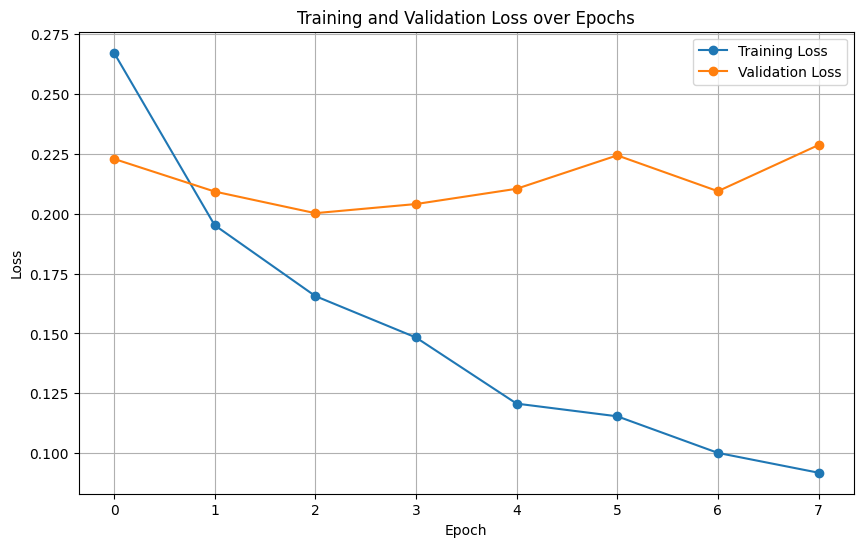

Final model saved.
Model berhasil disimpan di F_RCNN.pth
Model berhasil disimpan di F_RCNN.pth


In [23]:
# --- Inisialisasi dan Pelatihan ---
dataset_path = "/kaggle/input/guns-object-detection/"
full_dataset = GunData(dataset_path)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Terapkan augmentasi pada data training setelah split
train_dataset.dataset.transforms = train_transforms
val_dataset.dataset.transforms = val_transforms

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False, num_workers=2, collate_fn=collate_fn)

NUM_CLASSES = 2
rcnn_model = Model(NUM_CLASSES)
# Menambahkan weight_decay untuk L2 Regularization pada optimizer Adam
optimizer = optim.Adam(rcnn_model.model.parameters(), lr=0.0001, weight_decay=1e-5)

rcnn_model.train_and_validate(train_loader, val_loader, optimizer, num_epochs=50) # Menambah epoch maksimal untuk memberi kesempatan early stopping
rcnn_model.save_model()




In [24]:
# --- Bagian Prediksi Model ---

# Set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Menggunakan device: {device}")

# --- Load Model yang Sudah Terlatih ---
def get_model(num_classes):
    """Fungsi untuk memuat arsitektur model."""
    model = fasterrcnn_resnet50_fpn(pretrained=False) # False karena kita hanya memuat bobot
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def load_trained_model(model_path, num_classes):
    """Fungsi untuk memuat bobot model yang sudah dilatih."""
    model = get_model(num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval() # Atur model ke mode evaluasi
    return model

# Tentukan jalur file model Anda
MODEL_PATH = "best_model.pth" # Menggunakan model terbaik dari early stopping
NUM_CLASSES = 2 # 1 kelas objek (gun) + 1 kelas background
model = load_trained_model(MODEL_PATH, NUM_CLASSES)



Menggunakan device: cuda


In [25]:
# --- Fungsi Prediksi dan Visualisasi ---
def process_image_and_predict(image_path, model, score_threshold=0.7):
    """
    Memuat gambar, melakukan prediksi, dan mengembalikan hasil.
    Args:
        image_path (str): Jalur menuju file gambar.
        model (torch.nn.Module): Model Faster R-CNN yang sudah terlatih.
        score_threshold (float): Batasan skor untuk menampilkan bounding box.
    Returns:
        tuple: Tuple berisi gambar asli (numpy array) dan hasil prediksi.
    """
    # Memuat dan memproses gambar
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Tidak bisa memuat gambar dari {image_path}")
        return None, None
        
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_tensor = torch.as_tensor(image_rgb / 255.0).permute(2, 0, 1)

    # Lakukan prediksi
    with torch.no_grad():
        predictions = model([image_tensor.to(device)])
    
    # Ambil hasil dari prediksi pertama (batch_size = 1)
    preds = predictions[0]

    # Terapkan Non-Maximum Suppression (NMS)
    keep = torchvision.ops.nms(preds['boxes'], preds['scores'], iou_threshold=0.5)
    
    final_preds = {
        'boxes': preds['boxes'][keep].cpu().numpy(),
        'scores': preds['scores'][keep].cpu().numpy(),
        'labels': preds['labels'][keep].cpu().numpy()
    }
    
    # Filter hasil berdasarkan score_threshold
    filtered_preds = {
        'boxes': final_preds['boxes'][final_preds['scores'] > score_threshold],
        'scores': final_preds['scores'][final_preds['scores'] > score_threshold],
        'labels': final_preds['labels'][final_preds['scores'] > score_threshold]
    }
    
    return image, filtered_preds

def plot_predictions(original_image, predictions, title="Hasil Deteksi Objek"):
    """
    Menggambar bounding box dari prediksi pada gambar asli.
    """
    img_display = original_image.copy()
    
    if len(predictions['boxes']) == 0:
        print("Tidak ada objek yang terdeteksi dengan skor di atas threshold.")
    else:
        for box, score in zip(predictions['boxes'], predictions['scores']):
            # Ambil koordinat bounding box
            x1, y1, x2, y2 = box.astype(int)
            
            # Gambar bounding box
            cv2.rectangle(img_display, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Tulis skor di atas box
            label_text = f"Gun: {score:.2f}"
            cv2.putText(img_display, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Tampilkan gambar
    plt.figure(figsize=(12, 10))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()



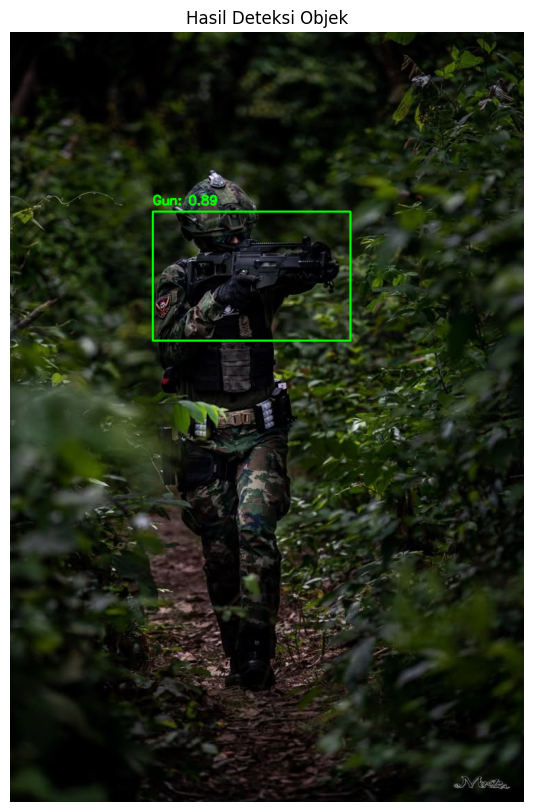

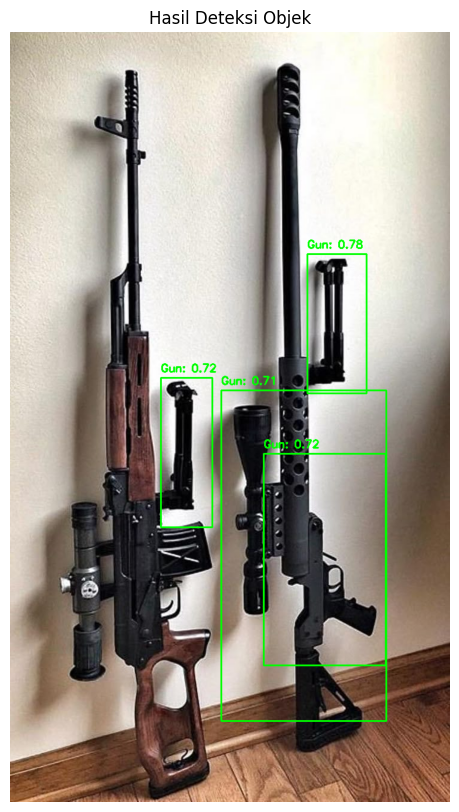

In [30]:
# --- Contoh Penggunaan ---
# Ganti dengan path gambar yang ingin Anda uji
TEST_IMAGE_PATH = "/kaggle/input/cobacoba/download.jpeg" 
# Lakukan prediksi
original_image, predictions = process_image_and_predict(TEST_IMAGE_PATH, model)

# Tampilkan hasil
if original_image is not None:
    plot_predictions(original_image, predictions)

# --- Contoh Penggunaan ---
# Ganti dengan path gambar yang ingin Anda uji
TEST_IMAGE_PATH2 = "/kaggle/input/chobi-chobi/download (3).jpeg" 
# Lakukan prediksi
original_image, predictions = process_image_and_predict(TEST_IMAGE_PATH2, model)

# Tampilkan hasil
if original_image is not None:
    plot_predictions(original_image, predictions)